# Machine Learning Workshop Practice : Part III

This part will show you how to:
1. implement Logistic Regression model without keras
1. optimize your model without keras

## Packages 

- [tensorflow](https://www.tensorflow.org) is a fundamental package for automatic differentiation (**still 2.X version**). 
- [numpy](http://www.numpy.org) is a package for fast math calculations.
- [sklearn](http://scikit-learn.org/stable/) provides metrics for performance measuring. 
- [matplotlib](http://matplotlib.org) is a library for plotting graphs in Python.

In [1]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix 
import matplotlib.pyplot as pyplot

In [2]:
SEED = 42
LEARNING_RATE = 0.005
LEARNING_RATE_DECAY = 0.95    # after each epoch learning rate will be exponentially decreased with this factor 
BATCH_SIZE = 1200
EPOCH = 45                    # total number of epochs
SHUFFLE_BEFORE_EPOCH = True   # if true then, before each epoch we are shuffling all data entries in the random order

## Dataset

In this section:
1. Loading dataset
1. Observing data
1. Flatting matrix to vectors
1. Binarizing labels

The **[MNIST](http://yann.lecun.com/exdb/mnist/)** dataset is used in this example.

The MNIST is still a database of handwritten digits. It has **60,000 examples as a training set and 10,000 examples as a test set**.
All the digits have been size-normalized and centered in a fixed-size
Therefore there is **no need to do any preprocessing**.

In [3]:
(X_train,y_train),(X_test,y_test) = tf.keras.datasets.mnist.load_data()

Let's look at the data closely.


Image shape:  (28, 28)
Number of classes:  10


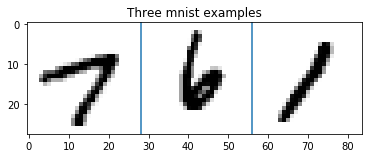

In [4]:
print("Image shape: ", X_train.shape[1:])
print("Number of classes: ", np.unique(y_train).shape[0])

img = np.concatenate([X_train[101], X_train[204], X_train[507]],axis=1)

pyplot.title("Three mnist examples")
pyplot.axvline(x=28)
pyplot.axvline(x=28*2)
pyplot.imshow(img, cmap=pyplot.cm.binary);

Each dataentry is a matrix of size **(28x28)** that contain brightness level of corresponding pixels.
Because each dataentry is essentially a digit, thus we have **10 classes** classification problem.


Unfortunately, Logistic Regression is not very suitable model for matrix input and multiclass classification. Let's have a fast fix for our problem.

First of all, we are going to replace matrixes with vectors.
To do that let's just perform row-wize flatting of each image from **(28, 28)** matrix to a vector of size **784**.



In [5]:
X_train = X_train.reshape((-1,28*28)).astype(np.float32)

Also for numerical stability let's again rescale data from range (0,255) to (0,1)

In [6]:
X_train = X_train.astype(np.float32) / 255

To convert mnist to a binary classification problem we define the
ratings of **{5,6,7,8,9} as positive** examples and all other ratings of **{0,1,2,3,4} as negative** ones.

In [7]:
y_train = (y_train>=5).astype(np.float32)

Please, repeat all of the preprocessing steps for test data.

In [8]:
### == START OF YOUR CODE == ###
X_test = X_test.reshape((-1,784)).astype(np.float32)
X_test = X_test / 255
y_test = (y_test >= 5).astype(np.float32)
### == END OF YOUR CODE == ###

In [9]:
print("Positive train: ", np.sum(y_train.astype(np.float32),dtype=np.int))
print("Negative train: ", y_train.shape[0]-np.sum(y_train.astype(np.float32),dtype=np.int))
print("Total train: ", y_train.shape[0])

print("Positive test: ", np.sum(y_test.astype(np.float32),dtype=np.int))
print("Negative test: ", y_test.shape[0]-np.sum(y_test.astype(np.float32),dtype=np.int))
print("Total test: ", y_test.shape[0])

Positive train:  29404
Negative train:  30596
Total train:  60000
Positive test:  4861
Negative test:  5139
Total test:  10000


## Logistic Regression model

In this section:
1. talking about model
1. loss function
1. optimization steps

Output of the model is a probability that given example is positive:
$$
P(y=1|x )= p = \sigma(logit) = \sigma(W^Tx+b)
$$


 

In [10]:
class LogisticRegression(object):
    def __init__(self, weigths_init=tf.keras.initializers.glorot_normal(seed=SEED), 
                        bias_init=tf.keras.initializers.constant(0.0)):
        self.weigths_init = weigths_init
        self.bias_init = bias_init

        self._W = None
        self._b = None

    def build(self, num_features):
        self.num_features = num_features
        self._W = tf.Variable(self.weigths_init([num_features,1]),trainable=True)
        self._b = tf.Variable(self.bias_init([1]),trainable=True)
    
    def predict(self, input):
        return self._predict(input).numpy()

    def loss(self, input, labels):
        assert input.shape[0] == labels.shape[0]
        return self._loss(input, labels).numpy()
    
    def train_step(self, input, labels, learning_rate):
        return self._train_step(input, labels, learning_rate).numpy()
    
    def __call__(self, input):
        return self._call(input).numpy()
    
    def get_variables(self):
        return [self._W, self._b]
    
    @tf.function
    def _train_step(self, input, labels, learning_rate):
        with tf.GradientTape() as t:
            current_loss = self._loss(input, labels)
        
        vars = self.get_variables()
        grads = t.gradient(current_loss, vars)
        
        # Stochastic Gradient Descent
        for v,g in zip(vars,grads):
            v.assign_sub(learning_rate * g)
        return current_loss
    
    ## == Functions to define == ##
    def _predict_logit(self, input):
        pass

    def _predict(self, input):
        pass
    
    def _loss(self, input, labels):
        pass
    
    def _call(self, input):
        pass

Recall the formula for logits. 
It is rewritten for the 
$$
\mathop{logit}\limits_{N\text{x}1} = \mathop{X}\limits_{N\text{x}F} \mathop{W}\limits_{F\text{x}1}+\mathop{b}\limits_{1\text{x}1}
$$

In tensorflow matrix multiplication is performed via
```
AB = tf.matmul(A, B)
```


In [11]:
@tf.function
def _predict_logit(self, input):
    '''
    self    is a LogisticRegression instance
    input   is a matrix of size (NxF)

    self._W is weigths matrix
    self._b is bias vector
    '''
    if self._W is None:
        self.build(input.shape[1])
    
    out = tf.matmul(input,self._W) + self._b 
    return tf.squeeze(out)    # we'd like output to be one-dimentional vector

Now let's obtain probabilities from logits

$$
\mathop{p}\limits_{N\text{x}1} = \sigma(\mathop{logit}\limits_{N\text{x}1})
$$

In tensorflow sigmoid function can be calculated by:
```
tf.nn.sigmoid(x) 
```

In [12]:
@tf.function
def _call(self, input):
    logits = self._predict_logit(input)
    out = tf.nn.sigmoid(logits)
    return out

Predicted probablility is an indicator that output probability is above threshold of 0.5. However it could be clearly seen from sigmoid plot that same result could be achived by testing sigmoid input on above zero.
$$
\hat{y} = [p>0.5] = [logit >0] 
$$

In [13]:
@tf.function
def _predict(self, input):
    logits =  self._predict_logit(input)
    out = logits > 0
    return tf.cast(out, tf.int32) # we'd like predictions to be of integer type

Binary form of Cross Entropy is used for this problem.
$$
L = - \sum_{i=1}^N y_i \log(p_i)+ (1-y_i) \log(1-p_i)
$$
For the reasons of numerical stability in actual implementation previous loss is replaced with more stable equivalent.
$$
L = \sum_{i=1}^N \max(logit_i,0) - y_ilogit_i + \log(1+\exp(-|logit_i|))
$$
In tensorflow this loss is represented by class *BinaryCrossentropy* with manually enabled *from_logits* option.

```python
tf.keras.losses.BinaryCrossentropy(from_logits=True)
```

In [14]:
LOSS_FUNCTION = tf.keras.losses.BinaryCrossentropy(from_logits=True)

@tf.function
def _loss(self, input, labels):
    logits = self._predict_logit(input)
    out = LOSS_FUNCTION(labels,logits)
    return out

In [15]:
class LogisticRegression(object):
    def __init__(self, weigths_init=tf.keras.initializers.glorot_normal(seed=SEED), 
                        bias_init=tf.keras.initializers.constant(0.0)):
        self.weigths_init = weigths_init
        self.bias_init = bias_init

        self._W = None
        self._b = None

    def build(self, num_features):
        self.num_features = num_features
        self._W = tf.Variable(self.weigths_init([num_features,1]),trainable=True)
        self._b = tf.Variable(self.bias_init([1]),trainable=True)
    
    def predict(self, input):
        return self._predict(input).numpy()

    def loss(self, input, labels):
        assert input.shape[0] == labels.shape[0]
        return self._loss(input, labels).numpy()
    
    def train_step(self, input, labels, learning_rate):
        return self._train_step(input, labels, learning_rate).numpy()
    
    def __call__(self, input):
        return self._call(input).numpy()
    
    def get_variables(self):
        return [self._W, self._b]
    
    @tf.function
    def _train_step(self, input, labels, learning_rate):
        with tf.GradientTape() as t:
            current_loss = self._loss(input, labels)
        
        vars = self.get_variables()
        grads = t.gradient(current_loss, vars)
        
        # Stochastic Gradient Descent
        for v,g in zip(vars,grads):
            v.assign_sub(learning_rate * g)
        return current_loss
    
    ## == Functions to define == ##
    def _predict_logit(self, input):
        return _predict_logit(self,input)

    def _predict(self, input):
        return _predict(self, input)
    
    def _loss(self, input, labels):
        return _loss(self, input, labels)
    
    def _call(self, input):
        return _call(self, input)

## Metrics and utilities

In this section:
1. train misc functions
1. observing metrics

It could be very hard to perform one train step on the whole dataset because of memory capacity. 
Therefore we are using minibatch updates.

In [16]:
def build_batch_generator(X, y, batch_size):
    num_batches = X.shape[0]//batch_size
    idxs = np.arange(num_batches*batch_size).reshape((num_batches,batch_size))
    
    def generator():
        for idx in idxs:
            yield X[idx], y[idx]
    
    return generator, num_batches

In [17]:
def build_shuffler():
    random_state = np.random.RandomState(SEED)
    
    def shuffler(X, y):
        idxs = np.arange(X.shape[0])
        random_state.shuffle(idxs)
        return X[idxs], y[idxs]
    
    return shuffler

In [18]:
def normalized_confusion_matrix(y_true, y_pred):
    conf_mat = confusion_matrix(y_true, y_pred)
    # confusion matrix is needed to be normalized 
    # to contain rates we would like to see 
    return conf_mat.astype(np.float32) / conf_mat.sum(axis=1)[:, None]

Our primary metrics are:
- Accuracy
- AUC ROC score

We also taking into consideration:
- Precision
- Recall
- F1-score
- Confusion Matrix

---
Would you like to know [more](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)?

In [19]:
def get_metrics(model, X, y, full_report=False):
    y_hat = model.predict(X)
    y_hat_probs = model(X)
    accuracy = accuracy_score(y, y_hat)
    auc_roc = roc_auc_score(y, y_hat_probs)
    if full_report:
        report = classification_report(y, y_hat, digits=2)
        conf_mat = normalized_confusion_matrix(y, y_hat)
        return accuracy, auc_roc, conf_mat, report
    else:
        return accuracy, auc_roc

## Training loop

In this section:
1. iteratively train model
1. collectig metrics




In [20]:
shuffler = build_shuffler()
model = LogisticRegression()

# we will collect metrics on each minibatch of each epoch
# NOTE: we are collecting primary metrics only (Accuracy and AUC ROC score)
train_accuracy_per_iteration = []
train_auc_roc_per_iteration = []
test_accuracy_per_iteration = []
test_auc_roc_per_iteration = []

learning_rate = LEARNING_RATE

### SOME MAGICAL PREPARATION TO IMITATE KERAS OUTPUT ###
### NOTHING TO BE SCARED OF ###
### HONESTLY (TRUST ME!) ###
progress_bar_str = "Epoch {{:<{}}} : [ {{}}{{}} ] ".format(int(np.log10(EPOCH))+1)
metrics_bar_str = "train accuracy: {{:.4f}} \t test accuracy {{:.4f}} \t learning rate: {{:.{}}}".format(
                        -int(np.floor(np.log10(LEARNING_RATE*LEARNING_RATE_DECAY**(EPOCH))))+1)
### END OF MAGIC HERE ###

In [21]:
for i in range(EPOCH):
    if SHUFFLE_BEFORE_EPOCH:
        X,y = shuffler(X_train,y_train)
    batch_gen, total_batches = build_batch_generator(X,y,BATCH_SIZE)
    total_batches -= 1

    for j, (batch_x, batch_y) in enumerate(batch_gen()):
        # performing mini-batch update
        model.train_step(batch_x, batch_y, learning_rate=0.01)

        # collecting train metrics
        accuracy, auc_roc = get_metrics(model, batch_x, batch_y)
        train_accuracy_per_iteration.append(accuracy)
        train_auc_roc_per_iteration.append(auc_roc)



        # collecting test metrics
        ### START YOUR CODE HERE ###
        accuracy, auc_roc = get_metrics(model, X_test, y_test)
        test_accuracy_per_iteration.append(accuracy)
        test_auc_roc_per_iteration.append(auc_roc)

        ### END OF YOUR CODE ###



        ### YET ANOTHER PORTION OF MAGIC ###
        print("\r", end="")
        points = int(j/total_batches*20)
        print(progress_bar_str.format(i+1,points*"+",(20-points)*"-"), end="")
        print(metrics_bar_str.format(train_accuracy_per_iteration[-1],accuracy,learning_rate), end="")
        ### END OF MAGIC HERE ###

    learning_rate *= LEARNING_RATE_DECAY
    print()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Epoch 1  : [ ++++++++++++++++++++ ] train accuracy: 0.7375 	 test accuracy 0.7169 	 learning rate: 0.005
Epoch 2  : [ ++++++++++++++++++++ ] train accuracy: 0.7342 	 test accuracy 0.7457 	 learning rate: 0.00475
Epoch 3  : [ ++++++++++++++++++++ ] train accuracy: 0.7500 	 test accuracy 0.7611 	 learning rate: 0.0045125
Epoch 4  : [ ++++++++++++++++++++ ] train accuracy: 0.7558 	 test accuracy 0.7718 	 learning rate: 0.0042869
Epoch 5  : [ ++++++++++++++++++++ ] train accuracy: 0.7600 	 test accuracy 0.7803 	 learning rate: 0.0040725
Epoch 6  : [ ++++++++++++++++++++ ] train accuracy: 0.8000 	 test accuracy 0.7891 	 learning rate: 0.0038689
Epoch 7  : [ ++++++++++++++++++++ ] train accuracy: 0.7850 	 test accuracy 0.7948 	 learning rate: 0.0036755
Epoch 8  : [ ++++++++++++++++++++ ] train accuracy: 0.7875 	 test accuracy 0.7990 	 learning rate: 0.0034917
Epoch 9  : [ ++++++++++++++++++++ ] train accuracy: 0

## Results

In this section:
1. observing learning curves
1. collecting **all** the metrics of trained model
1. plotting ROC curve

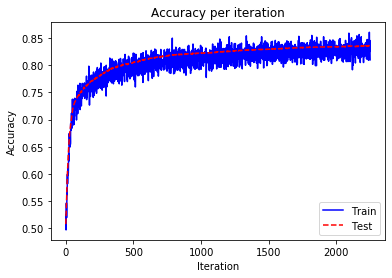

In [22]:
pyplot.plot(train_accuracy_per_iteration,"b-", label="Train")
pyplot.plot(test_accuracy_per_iteration,"r--", label="Test")
pyplot.title("Accuracy per iteration")
pyplot.xlabel("Iteration")
pyplot.ylabel("Accuracy")
pyplot.legend(loc="best")

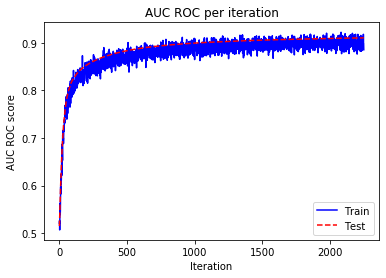

In [23]:
pyplot.plot(train_auc_roc_per_iteration,"b-", label="Train")
pyplot.plot(test_auc_roc_per_iteration,"r--", label="Test")
pyplot.title("AUC ROC per iteration")
pyplot.xlabel("Iteration")
pyplot.ylabel("AUC ROC score")
pyplot.legend(loc="best");

In [24]:
accuracy, auc_roc, conf_mat, report = get_metrics(model, X_train, y_train,full_report=True)
print("Training confusion matrix:\n", conf_mat)
print("Training accuracy: ", accuracy)
print("Training AUC: ", auc_roc)
print("Training classification report: \n", report)

Training confusion matrix:
 [[0.81870179 0.18129821]
 [0.15950211 0.84049789]]
Training accuracy:  0.8293833333333334
Training AUC:  0.9006970655653799
Training classification report: 
               precision    recall  f1-score   support

         0.0       0.84      0.82      0.83     30596
         1.0       0.82      0.84      0.83     29404

    accuracy                           0.83     60000
   macro avg       0.83      0.83      0.83     60000
weighted avg       0.83      0.83      0.83     60000



In [27]:
# metrics for test set
accuracy, auc_roc, conf_mat, report = get_metrics(model, X_test, y_test,full_report=True)
print("Testing confusion matrix:\n", conf_mat)
print("Testing accuracy: ", accuracy)
print("Testing AUC: ", auc_roc)
print("Testing classification report: \n", report)

Testing confusion matrix:
 [[0.81416618 0.18583382]
 [0.14071179 0.85928821]]
Testing accuracy:  0.8361
Testing AUC:  0.9101481989340642
Testing classification report: 
               precision    recall  f1-score   support

         0.0       0.86      0.81      0.84      5139
         1.0       0.81      0.86      0.84      4861

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



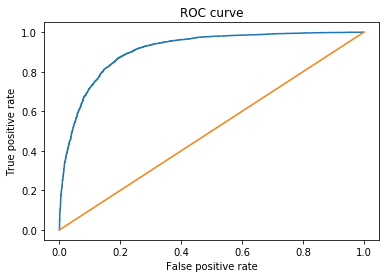

In [25]:
fpr, tpr, thresholds = roc_curve(y_test, model(X_test), drop_intermediate=True)

pyplot.plot(fpr, tpr, [0,1], [0, 1])
pyplot.title("ROC curve")
pyplot.xlabel("False positive rate")
pyplot.ylabel("True positive rate");

<p align="center">
  <b>THE END OF PART III</b>
</p>

